In [1]:
library(data.table)
## Assessing the quality of the genes in our remaining cells
matrix_destination = "matrix.cellQC.rds"
source("load_matrix.R")

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

## Filter Genes

If we were to plot the total number of (non-zero) genes per cell in a histogram, we would expect a normal distribution with long tails.

For high-seq depth, we would see something like this

 ![hemb_feat](https://hemberg-lab.github.io/scRNA.seq.course/14-exprs-qc_files/figure-html/total-features-hist-1.png)
 
 where a minimum cut-off line of 7000 genes is set to remove the cells with smaller gene libraries that are likely indicative of poor quality cells.
 
For low-seq depth data, such as what *we* are dealing with, our distribution looks like this:


FALSE  TRUE 
  106    26 

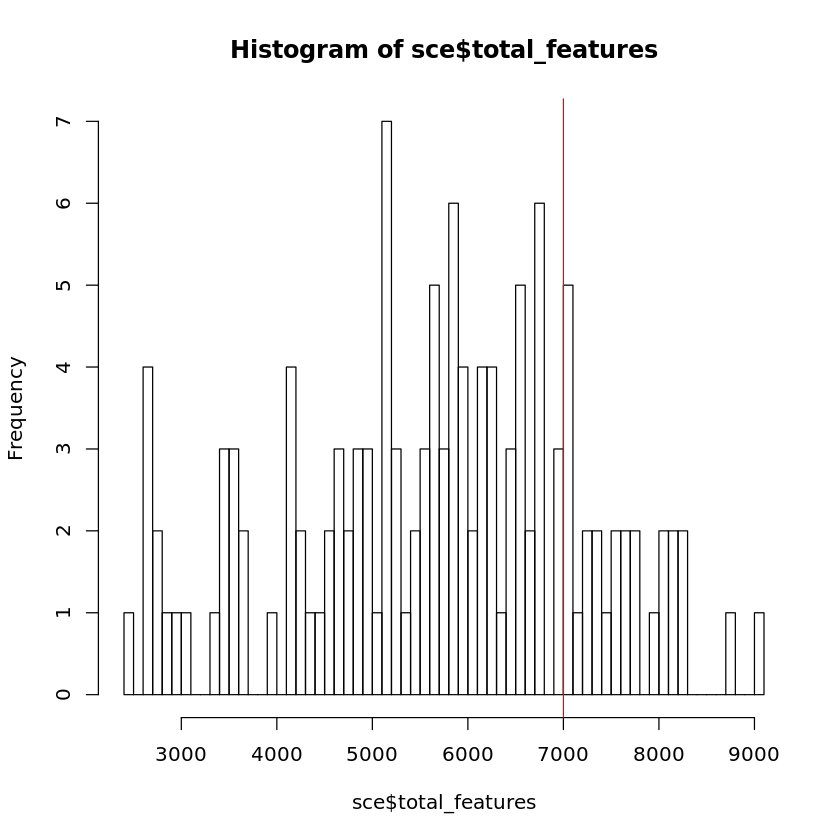

In [2]:
hist(sce$total_features, breaks=70)
abline(v = 7000, col = "red")

table(sce$total_features > 7000)

where just by applying the same threshold we would be left with only 13 cells. Note also that the high variability in the "distribution" due to there being only 192 cells in total.

Regardless of how noisy it appears, there may still be a signal to explore at a more acceptable threshold. 


#### Contending Issues: Gene Detectability

 1. Some genes may only exist in cells at low counts. This could mean very low expression, but we must filter above a noise threshold to determine significance. Filtering by this could produce a row of zeroes depending upon if we filter by:

   * **Individual cell-basis:** We zero-out only the individual transcript counts for specific cells if below a minumum expected threshold.
   * **Overall gene-bases:** We zero-out a whole gene if the total transcript counts across all cells are below a minumum expected threshold.
   
 2. Some genes that are known to exist in the source sample are simply not detected by the sequencing platform ("allelic drop-outs"). These often result in a row of zeroes and must be removed since there is no useful comparison that can be derived from them.
 
 3. Some genes only exist in only a limited number of cells. Depending on how high the number of UMI counts, they could be significant genes that outline rare cell types, or they could just be noise. We must determine a good minimum threshold of cells that our genes should be expressed by
   
#### Aims

 * Find a threshold of significance for the lowest number of cells that a gene can appear in.
 * Find a threshold of significance for the lowest number of observeable counts for a gene:
     * Cell-by-cell basis
     * Overall gene basis
     
##### Notes:

 * sce\$total_counts -- is total counts per cell
 * sce\$total_features -- is total genes per cell (or number of non-zero counts per cell)



 First let us look at the quality of the annotations that our gene transcripts have to find any inconsistencies 

In [3]:
message(sprintf("We have %5.0f     ENSMUS IDs, of which %5.0f are unique.",
    length(names(sce)), length(unique(sort(names(sce))))
))

message(sprintf("We have %5.0f       Gene IDs, of which %5.0f are unique.",
                length(rowData(sce)$external_gene_name), 
                length(unique(sort(rowData(sce)$external_gene_name)))
))

message(sprintf("We have %5.0f Transcript IDs, of which %5.0f are unique.",
                length(rowData(sce)$external_transcript_name),
                length(unique(sort(rowData(sce)$external_transcript_name)))
))


We have 21070     ENSMUS IDs, of which 21070 are unique.
We have 21070       Gene IDs, of which 21041 are unique.
We have 21070 Transcript IDs, of which 21048 are unique.


There appears to be a discrepancy of 22 transcripts. Let us examine them.

In [4]:
vec <- rowData(sce)$external_transcript_name
filter_duplicates <- rownames(sce) %in% names(
    sce[duplicated(vec) | duplicated(vec, fromLast=TRUE),]
)

# Table of the culprits
fair <- rowData(sce[filter_duplicates,])
name_fair <- names(fair)

mat <- matrix(unlist(fair), ncol=length(name_fair))
colnames(mat) <- names(fair)
mat <- data.frame(mat)

out_table <- data.table(mat)
out_table <- out_table[,c(9,1,16)]
colnames(out_table) <- c("Ensemble_89", "Ensemble_91", "Total_Counts")
#out_table


## 
getexpr = function(s,g){substring(s,g,g+attr(g,'match.length')-1)}
matcher <- '<div class="lhs">Status</div><div class="rhs"><p>([^<]*)</p>'

checkStatus <- function(rname){
    
    url_name <- paste(
        'http://www.ensembl.org/Mus_musculus/Gene/Idhistory?g=', rname,
        sep=""
    )
    page <- readLines(url_name)
    
    datalines <- grep(matcher, page, value=T)
    gg = gregexpr(matcher,datalines)
    matches = mapply(getexpr,datalines,gg)
    result = gsub(matcher,'\\1',matches)
    names(result) = NULL

    return(result)
}

alleg <- list()
for (ENS in fair$feature_id){
    alleg <- rbind(alleg, c(ENS, checkStatus(ENS)))
}
colnames(alleg) <- c("Ensemble_89", "Status")
alleg <- data.table(alleg)
cbind(out_table, alleg)[,c(1,2,3,5)]

Ensemble_89 Ensemble_91 Total_Counts       
1  NA          NA          0.00520833333333333
2  NA          NA          0.00520833333333333
3  NA          NA          0.03125            
4  NA          NA          0.0260416666666667 
5  NA          NA          0.00520833333333333
6  NA          NA          0.015625           
7  NA          NA          0.00520833333333333
8  NA          NA          0.0416666666666667 
9  NA          NA          0.114583333333333  
10 NA          NA          0.0104166666666667 
11 NA          NA          0.0104166666666667 
12 NA          NA          0.00520833333333333
13 NA          NA          0.00520833333333333
14 NA          NA          0.015625           
15 NA          NA          0.0989583333333333 
16 NA          NA          0.0104166666666667 
17 NA          NA          0.0885416666666667 
18 NA          NA          0.00520833333333333
19 NA          NA          0.104166666666667  
20 NA          NA          0.00520833333333333
21 NA          NA          0.015625           
22 NA          NA          0.03125            
   Status                                     
1  Retired (see below for possible successors)
2  Retired (see below for possible successors)
3  Retired (see below for possible successors)
4  Retired (see below for possible successors)
5  Retired (see below for possible successors)
6  Retired (see below for possible successors)
7  Retired (see below for possible successors)
8  Retired (see below for possible successors)
9  Retired (see below for possible successors)
10 Retired (see below for possible successors)
11 Retired (see below for possible successors)
12 Retired (see below for possible successors)
13 Retired (see below for possible successors)
14 Retired (see below for possible successors)
15 Retired (see below for possible successors)
16 Retired (see below for possible successors)
17 Retired (see below for possible successors)
18 Retired (see below for possible successors)
19 Retired (see below for possible successors)
20 Retired (see below for possible successors)
21 Retired (see below for possible successors)
22 Retired (see below for possible successors)

These genes are very poorly expressed, with no more than 22 total counts across all cells.  
A look through the ensembl database reveals also that all of these genes have been retired

We should remove these genes from the analysis if we wish to make sense of our data.

In [5]:
# Remove the low-covered genes
sce2 <- sce[(!(rowData(sce)$ensembl_gene_id %in% mat[order(mat$external_gene_name),]$ensembl_gene_id)),]

tab <- rbind(dim(sce), dim(sce2))
rownames(tab) <- c("Before Gene Filter", "After Gene Filter")
colnames(tab) <- c("Num Genes", "Num Cells")
tab

Num Genes Num Cells
Before Gene Filter 21070     132      
After Gene Filter  21048     132

One note of caution that was avoided in the last step is that if we filtered out any genes with total counts < 20 (as suggested by the poor depth of the retired genes), we would have lost half our data!

To show just how sensitive our data is to filtering at the gene level, we will explore different filtering thresholds:


## Gene Filtering

#### Methods

  1. We can define whether a gene is *detectable* or not by defining the minimum number of cells a gene must exist in after first being filtered for a total count of that gene against all cells.
 
  e.g. A sequencing threshold of 100 and minimum of 2 cells
  
  For each gene we sum their counts over all cells, and if the total is higher than 100, then we count how many cells these counts are distributed over where if it is over 2 cells, we keep it.
  
  2. Another approach is to do a by-cell threshold of 100 instead of total gene counts. This method is more stringent in filtering out genes that have a large abundance of counts in only a single cell. Whether or not it is significant to have a high signal from a single cell, is the question. 
  

In [6]:
cat("1) Example of filtering across the entire row, where gene counts are summed across all cells first and then the threshold is applied")
head( rowSums(counts(sce2)) )
head( rowSums(counts(sce2)) > 100)

cat("2) Example of filtering each cell containing a specific gene against the threshold first, and then counting the number of cells left behind\n")
head( rowSums(counts(sce2) > 100) )
head( rowSums(counts(sce2) > 100) ) > 0

cat("Row filtering does not cater for extreme cases where a single-cell contains all the counts for that gene (and all the rest are zero).")

1) Example of filtering across the entire row, where gene counts are summed across all cells first and then the threshold is applied

ENSMUSG00000000001 ENSMUSG00000000028 ENSMUSG00000000031 ENSMUSG00000000037 
               681                 80               1188                  5 
ENSMUSG00000000056 ENSMUSG00000000058 
                19                  3

ENSMUSG00000000001 ENSMUSG00000000028 ENSMUSG00000000031 ENSMUSG00000000037 
              TRUE              FALSE               TRUE              FALSE 
ENSMUSG00000000056 ENSMUSG00000000058 
             FALSE              FALSE

2) Example of filtering each cell containing a specific gene against the threshold first, and then counting the number of cells left behind


ENSMUSG00000000001 ENSMUSG00000000028 ENSMUSG00000000031 ENSMUSG00000000037 
                 0                  0                  4                  0 
ENSMUSG00000000056 ENSMUSG00000000058 
                 0                  0

ENSMUSG00000000001 ENSMUSG00000000028 ENSMUSG00000000031 ENSMUSG00000000037 
             FALSE              FALSE               TRUE              FALSE 
ENSMUSG00000000056 ENSMUSG00000000058 
             FALSE              FALSE

Row filtering does not cater for extreme cases where a single-cell contains all the counts for that gene (and all the rest are zero).

We will define methods for both approaches below, and compare the advantages/disadvtanges of both.

In [7]:
# Let's assign the proper gene names to our labels
rownames(sce2) <- rowData(sce2)$external_transcript_name

In [8]:
sce <- calculateQCMetrics(sce2)

# Approach 1: Filter based on data accumulated across an entire gene row
filterGeneRowsRange <- function(min_genes, min_seq)
{
    table <- data.frame()
    
    for (g in min_genes){
        for (s in min_seq){
            generows_truefalse <- rowSums(counts(sce)) >= s
            c_genes <- sum(generows_truefalse)
            c_cells <- sum(colSums(counts(sce[generows_truefalse,])) >= g)
            table <- rbind(table, c(s, g, c_genes, c_cells))
        }
    }
    colnames(table) <- c("SeqDep", "MinGene", "NumGenes", "NumCells")
    return(table)
}

# Approach 2: Filter based on individual data within a row
filterGeneSingleRange <- function(min_genes, min_seq)
{
    table <- data.frame()
    
    for (g in min_genes){
        for (s in min_seq){
            genes_truefalse <- rowSums( counts(sce) >= s ) > 0
            c_genes <- sum(genes_truefalse)
            c_cells <- sum(colSums(counts(sce[genes_truefalse,])) >= g)
            table <- rbind(table, c(s, g, c_genes, c_cells))
        }
    }
    colnames(table) <- c("SeqDep", "MinGene", "NumGenes", "NumCells")
    return(table)
}


gene_range <- seq(1,100,10)
trsh_range <- append(seq(1, 9, 1), append(seq(10, 90, 10), seq(100, 500, 20)))

results_rows <- filterGeneRowsRange(gene_range, trsh_range)
results_indiv <- filterGeneSingleRange(gene_range, trsh_range)

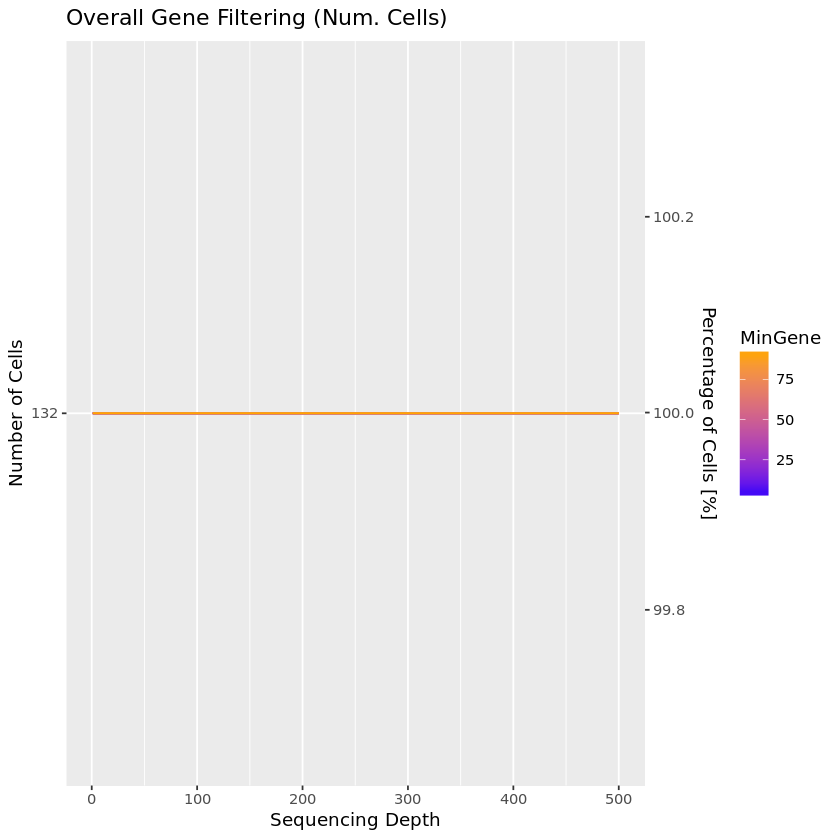

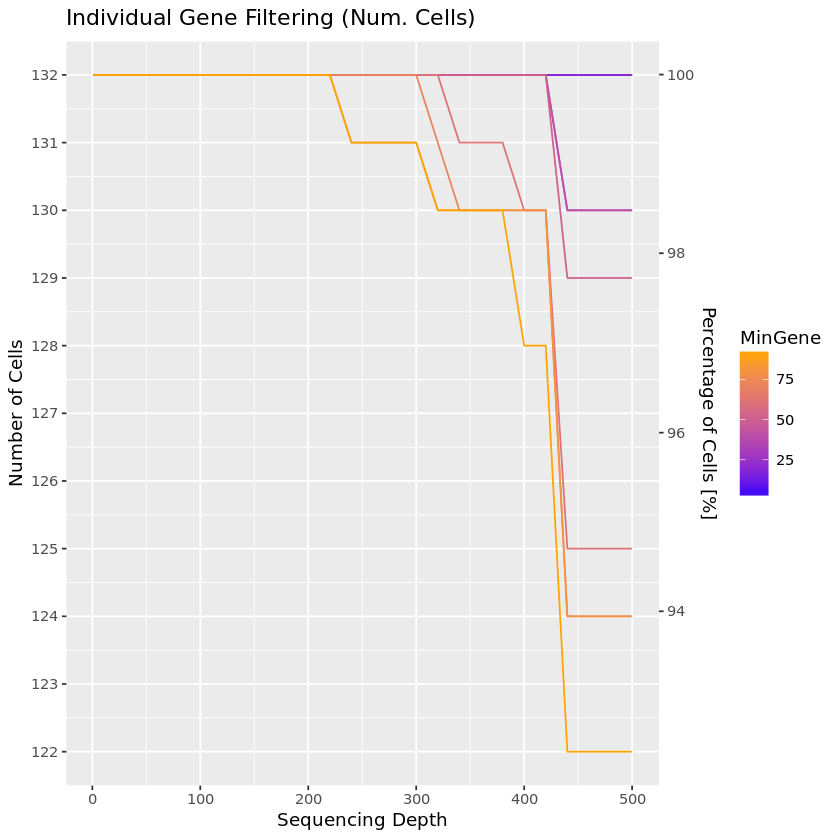

In [9]:
ranger1 <- append( seq(0,8,1), append(seq(10,29,10), append(seq(30,50,10), c(100,500) )))
total_genes <- dim(sce)[[1]]
total_cells <- dim(sce)[[2]]

ggplot(results_rows, aes(x = SeqDep, y = NumCells, colour = MinGene)
) + geom_line(aes(group=MinGene)
) + scale_y_continuous(breaks=seq(110,133,1),
    sec.axis = sec_axis(~./total_cells*100, name = "Percentage of Cells [%]",),
) + xlab("Sequencing Depth") + ylab("Number of Cells"
) + scale_color_continuous(low = "blue", high = "orange"
) + ggtitle("Overall Gene Filtering (Num. Cells)")

ggplot(results_indiv, aes(x = SeqDep, y = NumCells, colour = MinGene)
) + geom_line(aes(group=MinGene)
) + scale_y_continuous(breaks=seq(110,133,1),
    sec.axis = sec_axis(~./total_cells*100, name = "Percentage of Cells [%]",),
) + xlab("Sequencing Depth") + ylab("Number of Cells"
) + scale_color_continuous(low = "blue", high = "orange"
) + ggtitle("Individual Gene Filtering (Num. Cells)")


#plotQC(sce, type="high")
#plotQC(sce, type="high")

From these graphs we can determine several things:

#### Number of cells

 1. (Both charts) The number of cell columns is not significantly affected by the number of filtered gene rows. This proves that there is a good distribution of gene counts across all cells of a given gene row, and so no cells are over-expressing one particular gene.
 
 2. (Bottom chart) The number of cells is also not significantly affected by the number of times a gene must be detected across a certain amount of cells ("MinGene"), except when filtering for extreme cells. For example, the purple bar in the top right corner, 1 cell is lost because there were not 30 cells expressing read counts higher than 420, resulting in some gene rows being lost and 1 cell column becoming zero. The orange bar at the bottom is more extreme version where 10 cells are lost because there were not 100 cells expressing readcounts higher than 420.
 
 What this ultimately means is that there is little variability in the number of cells if we filter up to 200 reads (either globally across each gene, or individual across each cell for each gene).

**Number of Genes**

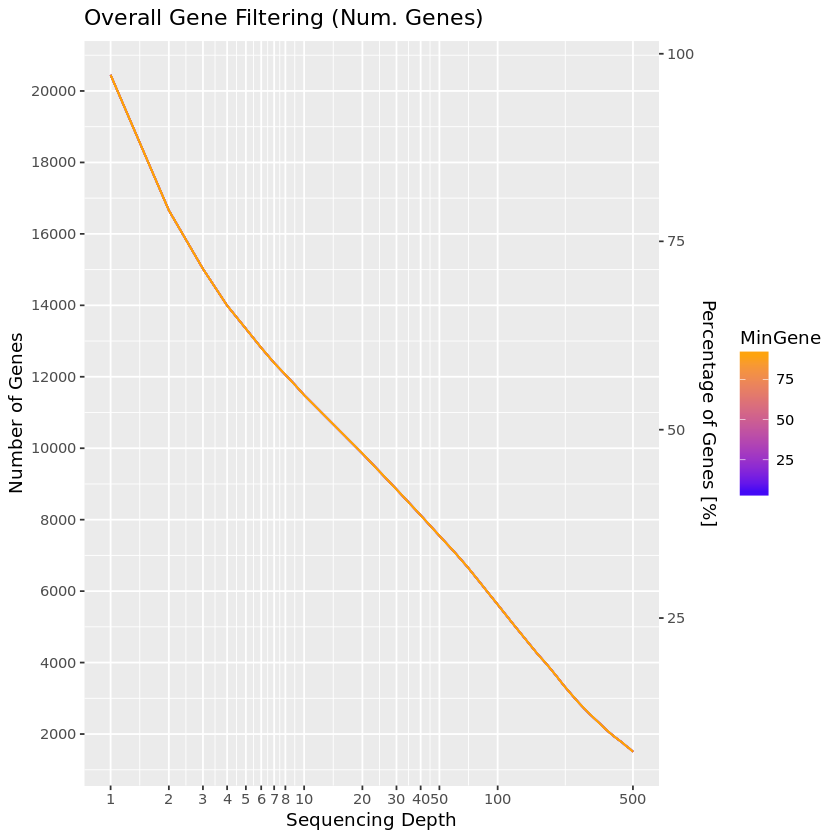

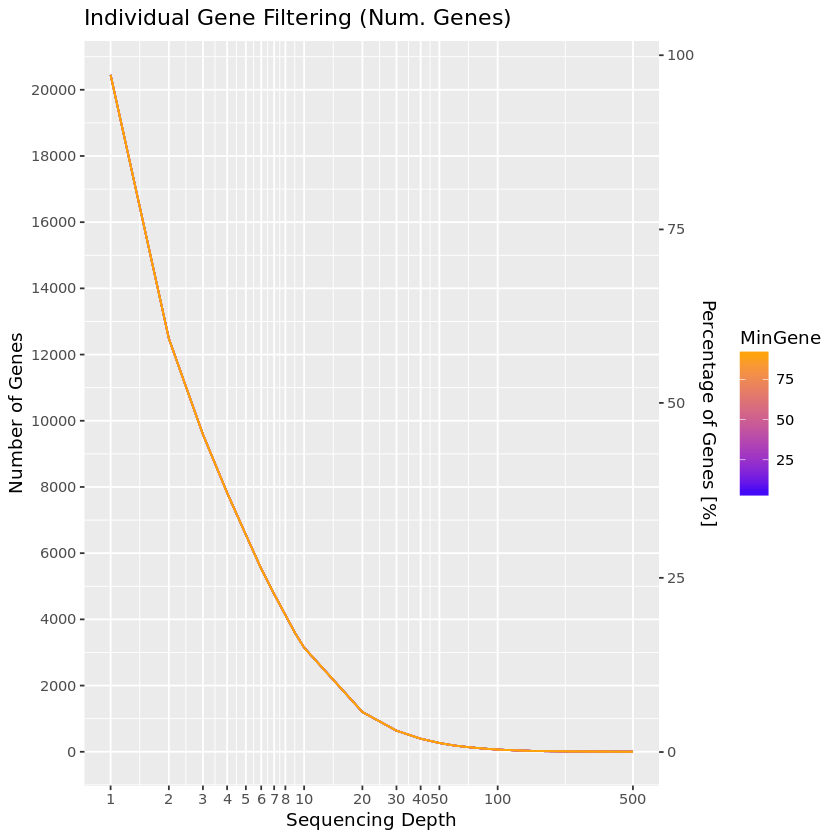

In [10]:
ggplot(results_rows, aes(x=SeqDep, y=NumGenes, colour=MinGene)
) + geom_line(aes(group=MinGene)
) + scale_x_log10(breaks=ranger1, limits=c(1,500)
) + scale_y_continuous(
    sec.axis = sec_axis(~./total_genes*100, name = "Percentage of Genes [%]",),
    breaks=seq(0,30000,2000)
) + xlab("Sequencing Depth") + ylab("Number of Genes"
) + scale_color_continuous(low = "blue", high = "orange"
) + ggtitle("Overall Gene Filtering (Num. Genes)")

ggplot(results_indiv, aes(x=SeqDep, y=NumGenes, colour=MinGene)
) + geom_line(aes(group=MinGene)
) + scale_x_log10(breaks=ranger1, limits=c(1,500)
) + scale_y_continuous(
    sec.axis = sec_axis(~./total_genes*100, name = "Percentage of Genes [%]",),
    breaks=seq(0,30000,2000)
) + xlab("Sequencing Depth") + ylab("Number of Genes"
) + scale_color_continuous(low = "blue", high = "orange"
) + ggtitle("Individual Gene Filtering (Num. Genes)")


Once again we do not see any change in the number of detected genes if we range the minimum number of cells between 1-100. Let us combine the above plots into one.

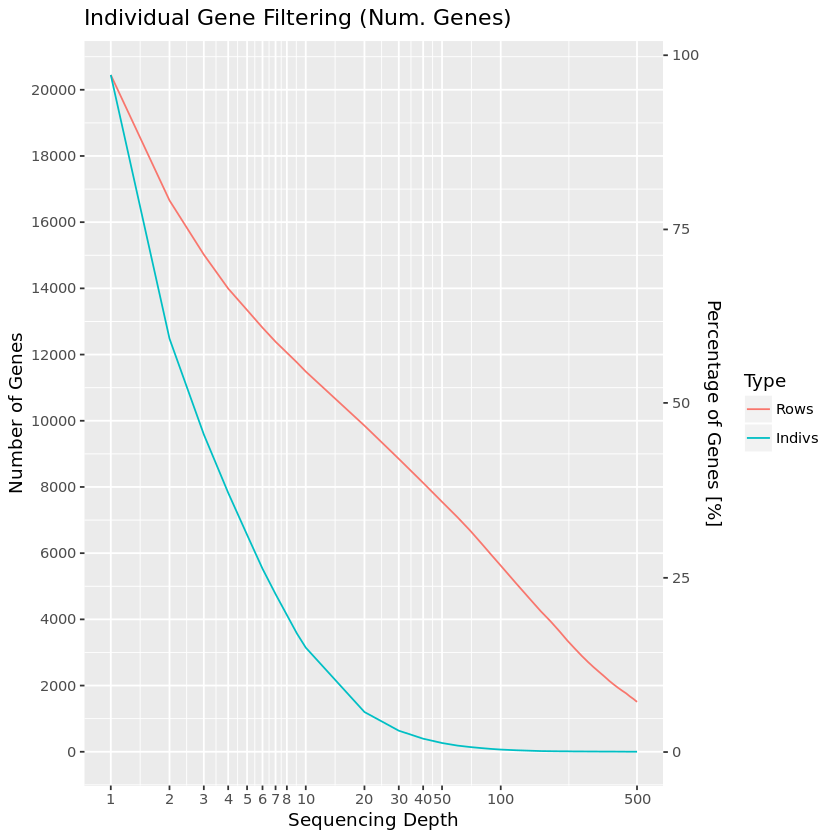

In [11]:
# No real variation from MinGene values, let's combine plots of MinGene==1

#rbind(
res_row <- cbind("Rows", results_rows[results_rows$MinGene == 1,  ][c(1,3,4)])
names(res_row)  <- c("Type", "SeqDep", "NumGenes", "NumCells")

res_ind <- cbind("Indivs", results_indiv[results_indiv$MinGene == 1,][c(1,3,4)])
names(res_ind) <- c("Type", "SeqDep", "NumGenes", "NumCells")

res_combined <- rbind(res_row, res_ind)

# combine plot
ggplot(res_combined, aes(x=SeqDep, y=NumGenes, colour=Type)
) + geom_line(aes(group=Type)
) + scale_x_log10(breaks=ranger1, limits=c(1,500)
) + scale_y_continuous(
    sec.axis = sec_axis(~./total_genes*100, name = "Percentage of Genes [%]",),
    breaks=seq(0,30000,2000)
) + xlab("Sequencing Depth") + ylab("Number of Genes"
) + ggtitle("Individual Gene Filtering (Num. Genes)"
#) + geom_vline(xintercept=5, col = "red", alpha = 0.7, linetype="dotted"
#) + geom_hline(yintercept=5000, col = "red", alpha = 0.7, linetype="dotted"
#) + annotate("text", x = 5, y=130 + 0.7, 
#             label = "threshold of evenness", color = "red", size = 3, alpha = 0.7)
)


#### Number of genes

 1. (Two main charts above) The number of genes is not at all affected by the number of minimum number of cells needed to make that gene 'detectable', again showing that gene read counts are distributed over many cells (more than 100 at least).
 
 2. (Combined chart) The individual cell filtering has a steeper curve and a much harsher effect of filtering because we are essentially defining a minimum baseline of detection for ALL cells and genes. This rationale might seem fair and just, but it assumes that there is no significant variation of expression between cells, and therefore all cells should be treated equally.
 
 3. (Combined chart) The overall gene-wise red "row" curve is less steep, and diverges significantly from the individual curve. This tells us one major thing:
 
   Although the number of cells to which the overall gene expression can be attributed to is over 100, the *proportion* of those counts are not even (as expected) and so individual cell-gene filtering has a much more profound effect on non-zero counts that are still fairly low.
   
   It should be noted that the cell-to-cell variation is also assumed to be the same across cells via the overall gene expression filtering approach.
   
   
#### What to do?

 * Define a minimum threshold of detectability that is independent of any gene or cell.
 
 This should be fairly low, since as we can see from the above chart - even filtering for just 5 counts, can reduce the total number of genes down from 20,000 to 6,000. 
 
  
 * Define a minimum threshold of count significance for a gene overall.
 
 We only want significant genes that we can compare across the range of cells that we have, so we should set a threshold.
 
#### We will aim for a minimum threshold of 5000 genes to compare.

From the charts above, this defines:

 1. Min thresh of detectability: 5
 2. Min thresh of overall gene signal:  100

In [117]:
# plotting variation of total_features yields identical boxplots

#feature_table <- data.frame()
#
#for (thresh in trsh_range){
#    new_sce <- sce[rowSums(counts(sce)) > thresh,]
#    feature_table <- rbind(feature_table, cbind( c(thresh), new_sce$total_features))
#}
#
#names(feature_table) <- c("SeqThreshold", "AllExprValues")
#ggplot(feature_table, aes(x = factor(SeqThreshold), y = AllExprValues, group =SeqThreshold)
#) + geom_boxplot(notch=T, outlier.shape = NA, fill = "red", alpha = 0.2,
#) + xlab("Sequencing Depth"
#) + ylab("Gene expression values"
#)

In [12]:
indiv_thresh = 5
row_thresh = 100

sce_minthresh_detect <- sce[rowSums(counts(sce) > indiv_thresh) > 0,]
sce_minthresh_genes <- sce_minthresh_detect[rowSums(counts(sce_minthresh_detect)) > row_thresh,]

tableau <- rbind(
    dim(sce),
    dim(sce_minthresh_detect),
    dim(sce_minthresh_genes)
)

colnames(tableau) <- c("Num Genes", "Num cells")
rownames(tableau) <- c("All", "Indiv > 5", " & Gene > 100")
tableau

#plotQC(sce, type="high")
#plotQC(sce_minthresh_detect, type="high")
#plotQC(sce_minthresh_genes, type="high")

Num Genes Num cells
All           21048     132      
Indiv > 5      5530     132      
 & Gene > 100  5052     132

In [13]:
saveRDS(sce_minthresh_genes, "matrix.cellQC.geneQC.rds")